### Importing Necessary Libraries

In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2S, Xception
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [6]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

We will be using the image data above and the ROI extraction data as explained [here](RoI-Extraction.ipynb).

In [7]:
BATCH_SIZE = 50
INPUT_SHAPE = (800, 600)

Now due to the quite varying nature of the ROI shapes, the following pre-processing steps on each ROI converts them to same shape as that of the original document images by resizing and padding with the maximum color in the ROI which is mostly white and sometimes greyish, etc.

In [8]:
def resize_and_pad_with_doc_max_col(img, f_target_height=INPUT_SHAPE[0], f_target_width=INPUT_SHAPE[1]):
    f_width = img.shape[1]
    f_height = img.shape[0]
    ratio = np.max([f_width / f_target_width, f_height / f_target_height])
    resized_height_float = f_height / ratio
    resized_width_float = f_width / ratio
    resized_height = tf.cast(
        np.floor(resized_height_float), dtype=tf.int32)
    resized_width = tf.cast(
        np.floor(resized_width_float), dtype=tf.int32)

    padding_height = (f_target_height - resized_height_float) / 2
    padding_width = (f_target_width - resized_width_float) / 2
    f_padding_height = np.floor(padding_height)
    f_padding_width = np.floor(padding_width)
    p_height = np.max([0, tf.cast(f_padding_height, dtype=tf.int32)])
    p_width = np.max([0, tf.cast(f_padding_width, dtype=tf.int32)])

    resized_padded_image = tf.image.resize_with_pad(img, f_target_height, f_target_width).numpy()
    white_color = np.max(resized_padded_image)
    resized_padded_image[:p_height, :] = white_color
    resized_padded_image[(f_target_height-p_height-1):, :] = white_color
    resized_padded_image[:, :p_width] = white_color
    resized_padded_image[:, (f_target_width-p_width-1):] = white_color
    return resized_padded_image

The data generator as created below does the following things:
- It uses the RoI extraction information and the image to extract the portions of the document image and returns a list of these snippet regions.

In [9]:
class ROIGenerator:
    def __init__(self, df, df_roi, X_col, roi_pad=5):
        self.paths = list(df[X_col])
        self.roi_info = df_roi
        self.num_images = df_roi.shape[0]
        self.roi_pad = roi_pad
        self.idx = 0
        
    def generate(self):
        while True:
            if self.idx >= self.num_images:
                self.idx = 0
            image_data = img_to_array(load_img(self.paths[self.idx]))
            roi_data = self.roi_info[self.idx]
            self.idx += 1
            yield [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)]) if pad_mask == 1 else [[]] for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data]

In [10]:
test_gen = ROIGenerator(
    df=train_labels,
    df_roi=roi_info,
    X_col='images'
)

Below is the generated ROI extractions per image depicted.

Metal device set to: Apple M1 Max


2022-10-07 04:23:43.639310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-07 04:23:43.639677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


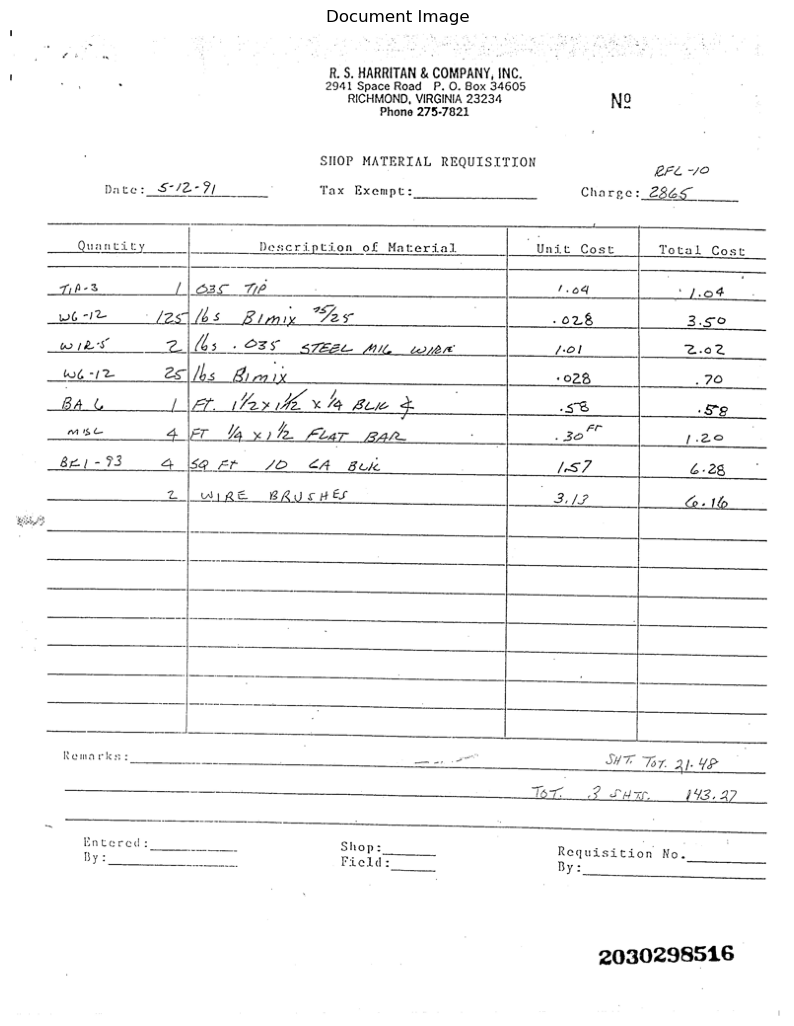

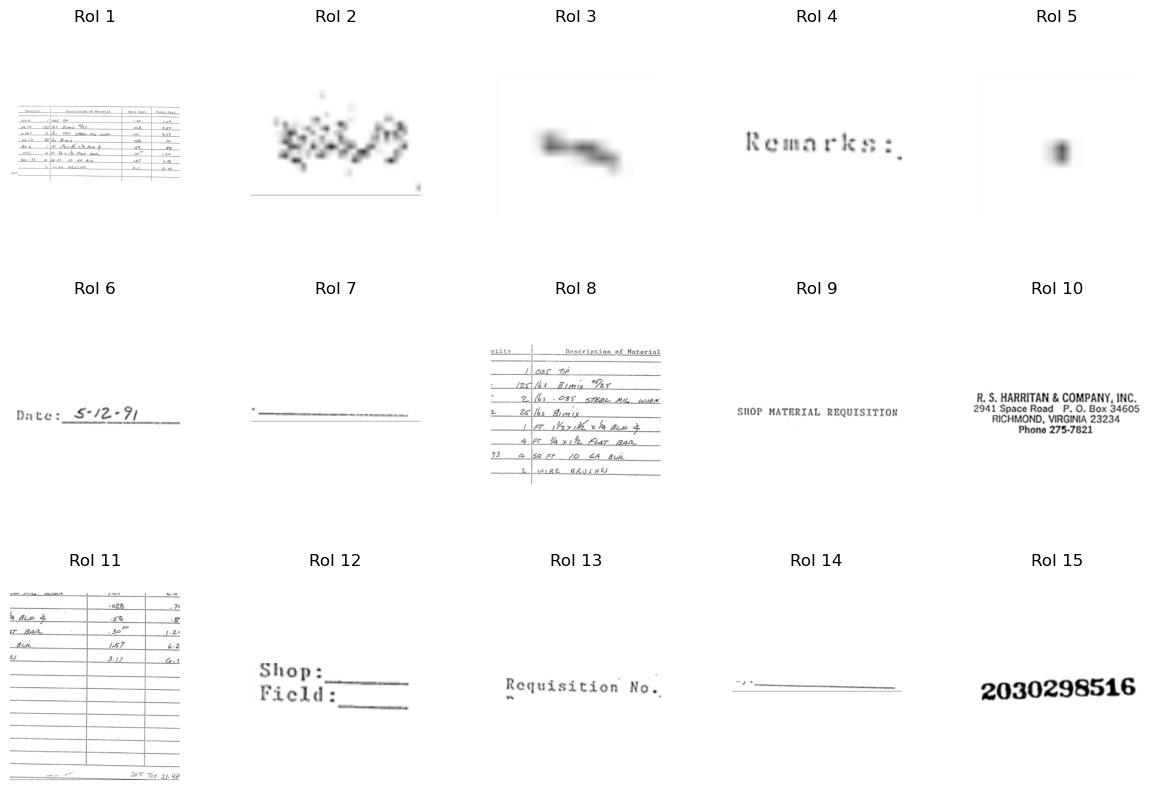

In [11]:
plt.figure(figsize=(10,20))
plt.imshow(tf.cast(img_to_array(load_img('./Data/train/train/0.tif')), dtype=tf.uint8))
plt.axis('off')
plt.title("Document Image")

imgs = next(test_gen.generate())
fig, ax = plt.subplots(3, 5, figsize=(15,10))
k = 0
for i in range(3):
    for j in range(5):
        if len(imgs[k]) != 0:
            ax[i,j].imshow(tf.cast(imgs[k], dtype=tf.uint8))
            ax[i,j].axis('off')
            ax[i,j].set_title(f'RoI {k+1}')
        k += 1

Now, after we have seen how each document image is processed which is an extension to the [4 Piece Add On Model's](EfficientNet-4Piece-Model.ipynb) pre-processing which worked with only 4 pieces.

In [12]:
class ImageDataGenerator:
    def __init__(self, df, X_col, roi_info, y_col, batch_size, roi_pad=5, input_size=(800, 600), shuffle=True, base=0):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.roi_info = roi_info # Contains valid information for the pre-processing of each image
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.roi_pad = roi_pad # Padding on 4 sides for each ROI
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
        self.base=base # base value
        
    def __get_input(self, path):
        image_data = img_to_array(load_img(path))
        idx = int(path.split('/')[-1].split('.')[0]) - self.base
        # some other pre-processing / data-augmentation goes here
        roi_data = self.roi_info[idx]
        return [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)])/255.0 for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data if pad_mask == 1]

    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch = [np.array(self.__get_input(path)) for path in batch_paths]
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [13]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

In [14]:
# batch = train_generator[0]
# print('*** Batch Overview ***')
# print('Batch Size:', len(batch[0]))
# for i in range(BATCH_SIZE):
#     print(f'Number of ROIs for the {i+1}th input image:', batch[0][i].shape[0])
# print('ROI Dimensions:', batch[0][0].shape[1:])
# print('Output Label Tensor Shape:', batch[1].shape)
# del batch

Because of too many images, the batch visualization is not provided but it is similar to that of above shown for one document which is equivalent to batch size of 1.

## Model Building

After building a couple of CNN models consdering only the entire document image [EfficientNet Only Model](EfficientNet-Only-Model.ipynb) and [4 Piece Add On Model](EfficientNet-4Piece-Model.ipynb). It is now time to build much more better models considering other structures we will start by incorporating the ROI visual features and then later much more.

We will use the following pre-trained model to learn features for these ROIs.

- EfficientNetV2L

The EfficientNetV2L is a large model and since, we are not pre-training the entire model, we will just fine-tune it with few extra layers. So, to fasten training we precompute the output of the EfficientNetV2L model and use this for training the added Dense Layers for Fine-Tuning.

In [14]:
model_xception = Xception(weights="imagenet", input_shape=(*INPUT_SHAPE, 3), include_top=False)
# model_effnet = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(*INPUT_SHAPE, 3))
# model_effnet.trainable = False
model_xception.trainable = False

In [15]:
inp = Input(shape=(*INPUT_SHAPE, 3))
# out = model_effnet(inp, training=False)
out = model_xception(inp, training=False)
output = GlobalAvgPool2D()(out)
# model = tf.keras.Model(inp, output, name='EfficientNet-kPiece')
model = tf.keras.Model(inp, output, name='Xception-kPiece')

In [22]:
model.predict(batch[-25:])

2022-10-01 11:07:13.496124: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 11:07:13.720512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


array([[4.99584060e-03, 4.25433293e-02, 9.93836671e-02, ...,
        3.21301445e-03, 2.59823762e-02, 9.08260979e-03],
       [2.50613055e-04, 1.18759666e-02, 0.00000000e+00, ...,
        1.77203789e-02, 7.71604702e-02, 1.28602296e-01],
       [3.41954082e-02, 1.82092339e-02, 5.07147610e-03, ...,
        7.09404126e-02, 9.45318267e-02, 2.69510925e-01],
       ...,
       [0.00000000e+00, 5.16504236e-03, 4.90547449e-04, ...,
        4.62833559e-04, 9.43152513e-03, 1.17826145e-02],
       [0.00000000e+00, 4.64747474e-03, 0.00000000e+00, ...,
        1.21422185e-04, 4.47714329e-03, 1.92385539e-02],
       [0.00000000e+00, 1.29655155e-03, 4.02751788e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.20959717e-01]], dtype=float32)

In [29]:
model.predict(batch[-25:-23])

1/1 [==============================] - 0s 186ms/step


array([[0.00499583, 0.04254334, 0.09938344, ..., 0.00321299, 0.02598238,
        0.00908261],
       [0.00025061, 0.01187593, 0.        , ..., 0.01772035, 0.07716057,
        0.12860212]], dtype=float32)

In [28]:
model_xception.predict(batch[-25:]).shape

1/1 [==============================] - 1s 896ms/step


(25, 25, 19, 2048)

In [54]:
model.predict(batch)[-25:]

26/26 [==============================] - 34s 1s/step


array([[1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       ...,
       [1.7318112e-05, 3.6561041e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924841e-02, 0.0000000e+00],
       [1.7318112e-05, 3.6561041e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924841e-02, 0.0000000e+00],
       [1.7318112e-05, 3.6561041e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924841e-02, 0.0000000e+00]], dtype=float32)

In [53]:
model.predict(batch[-25:])

1/1 [==============================] - 1s 868ms/step


array([[4.99584060e-03, 4.25433293e-02, 9.93836671e-02, ...,
        3.21301445e-03, 2.59823762e-02, 9.08260979e-03],
       [2.50613055e-04, 1.18759666e-02, 0.00000000e+00, ...,
        1.77203789e-02, 7.71604702e-02, 1.28602296e-01],
       [3.41954082e-02, 1.82092339e-02, 5.07147610e-03, ...,
        7.09404126e-02, 9.45318267e-02, 2.69510925e-01],
       ...,
       [0.00000000e+00, 5.16504236e-03, 4.90547449e-04, ...,
        4.62833559e-04, 9.43152513e-03, 1.17826145e-02],
       [0.00000000e+00, 4.64747474e-03, 0.00000000e+00, ...,
        1.21422185e-04, 4.47714329e-03, 1.92385539e-02],
       [0.00000000e+00, 1.29655155e-03, 4.02751788e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.20959717e-01]], dtype=float32)

In [23]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [24]:
model.summary()

Model: "EfficientNet-kPiece"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 800, 600, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 25, 19, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 20,331,360
Trainable params: 0
Non-trainable params: 20,331,360
_________________________________________________________________


### Training Data

In [22]:
train_generator_precompute = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
precompute_output = list()

In [18]:
batch_data = np.load(f'./Data/EffNet-kP-train-precompute/train_data_precomp-{160}.npy')

In [21]:
batch_roi = roi_count[(159*(BATCH_SIZE*checkpnt_i)):((160)*(BATCH_SIZE*checkpnt_i))]

In [22]:
batch_roi[-1]

25

In [23]:
batch_data[-25:].shape

(25, 1280)

In [63]:
batch_data[-25:]

array([[-0.12089735, -0.1074025 , -0.07851195, ..., -0.06743688,
        -0.07724361, -0.11426939],
       [-0.12089735, -0.1074025 , -0.07851195, ..., -0.06743688,
        -0.07724361, -0.11426939],
       [-0.12089735, -0.1074025 , -0.07851195, ..., -0.06743688,
        -0.07724361, -0.11426939],
       ...,
       [-0.12089745, -0.10740255, -0.07851197, ..., -0.06743691,
        -0.07724371, -0.11426939],
       [-0.12089745, -0.10740255, -0.07851197, ..., -0.06743691,
        -0.07724371, -0.11426939],
       [-0.12089745, -0.10740255, -0.07851197, ..., -0.06743691,
        -0.07724371, -0.11426939]], dtype=float32)

In [18]:
batch = train_generator_precompute[159]
batch = [x for x in batch[0] if len(x.shape) == 4]
batch = tf.concat(batch, axis=0)

In [19]:
batch.shape

TensorShape([803, 800, 600, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


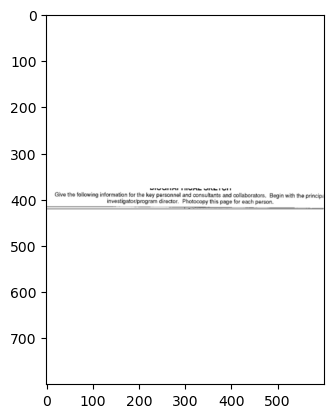

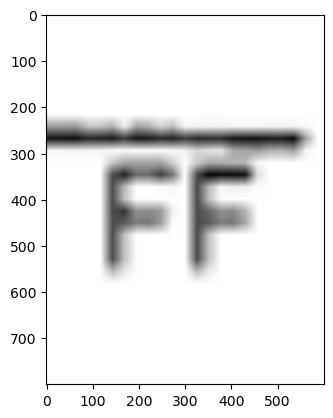

In [22]:
plt.imshow(batch[-10])
plt.figure()
plt.imshow(batch[-1])

In [26]:
model.predict(batch[0:2])

1/1 [==============================] - 0s 185ms/step


array([[0.        , 0.03106768, 0.11801394, ..., 0.00026925, 0.05165518,
        0.03237382],
       [0.        , 0.00131591, 0.        , ..., 0.        , 0.08042553,
        0.16655542]], dtype=float32)

In [25]:
model.predict(batch[-25:])

2022-10-01 10:49:30.911810: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 10:49:31.866375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


array([[-0.08700193, -0.15693967, -0.15306118, ..., -0.16252252,
        -0.15232824, -0.09316948],
       [-0.11283376, -0.14817429, -0.15734507, ..., -0.1500721 ,
        -0.13122194, -0.14092587],
       [-0.12477755, -0.15253575, -0.14406776, ..., -0.1548581 ,
        -0.10168298, -0.16158009],
       ...,
       [-0.10993081, -0.15154561, -0.16802101, ..., -0.15535904,
        -0.13939328, -0.13257605],
       [-0.11789181, -0.15854682, -0.16861778, ..., -0.1561487 ,
        -0.14531821, -0.14729665],
       [-0.15194653, -0.16035464, -0.16172677, ..., -0.17331012,
        -0.1656515 , -0.15626767]], dtype=float32)

In [28]:
model.predict(batch[-25:-23])

1/1 [==============================] - 0s 106ms/step


array([[-0.08700199, -0.15693976, -0.1530612 , ..., -0.16252257,
        -0.15232825, -0.09316951],
       [-0.11283376, -0.14817433, -0.15734506, ..., -0.1500722 ,
        -0.1312221 , -0.14092587]], dtype=float32)

In [49]:
batch.shape

TensorShape([803, 800, 600, 3])

In [24]:
model.predict(batch)[-25:-20]

26/26 [==============================] - 34s 1s/step


array([[1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


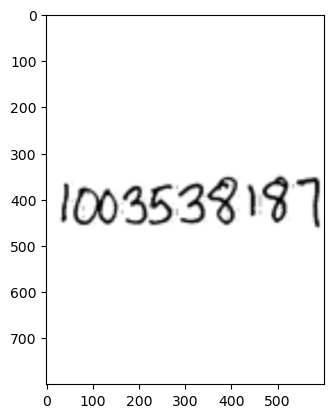

In [40]:
plt.imshow(batch[-58])

In [44]:
model.predict(batch[-58:])

1/1 [==============================] - 2s 2s/step


array([[5.3905282e-04, 2.8516021e-02, 1.2775734e-03, ..., 5.4674568e-03,
        1.7451918e-02, 9.4717339e-02],
       [0.0000000e+00, 2.8345605e-02, 1.2786543e-03, ..., 0.0000000e+00,
        2.4870334e-03, 1.2716405e-01],
       [4.3588653e-03, 8.2868971e-02, 1.8764129e-02, ..., 2.5320805e-03,
        5.9973758e-02, 6.9927111e-02],
       ...,
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00],
       [1.7320104e-05, 3.6561250e-04, 0.0000000e+00, ..., 0.0000000e+00,
        3.5924271e-02, 0.0000000e+00]], dtype=float32)

In [45]:
model.predict(batch[-57:])

1/1 [==============================] - 2s 2s/step


array([[0.00000000e+00, 2.56574154e-02, 1.79693177e-01, ...,
        2.85670068e-03, 1.08444700e-02, 2.34257965e-03],
       [0.00000000e+00, 1.28444552e-03, 0.00000000e+00, ...,
        4.11680201e-03, 4.49061068e-03, 1.83695972e-01],
       [0.00000000e+00, 2.29660165e-03, 7.84890354e-03, ...,
        1.86224483e-04, 1.81426702e-03, 1.54079705e-01],
       ...,
       [0.00000000e+00, 5.16504236e-03, 4.90547449e-04, ...,
        4.62833559e-04, 9.43152513e-03, 1.17826145e-02],
       [0.00000000e+00, 4.64747474e-03, 0.00000000e+00, ...,
        1.21422185e-04, 4.47714329e-03, 1.92385539e-02],
       [0.00000000e+00, 1.29655155e-03, 4.02751788e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.20959717e-01]], dtype=float32)

In [43]:
model.predict(batch[-55:])

2/2 [==============================] - 2s 1s/step


array([[0.00000000e+00, 2.29660165e-03, 7.84890354e-03, ...,
        1.86224483e-04, 1.81426702e-03, 1.54079705e-01],
       [4.94572960e-05, 8.04292504e-04, 5.08825444e-02, ...,
        4.58029518e-03, 2.09121332e-02, 5.57549708e-02],
       [0.00000000e+00, 1.62312540e-03, 0.00000000e+00, ...,
        4.35817856e-05, 2.16606092e-02, 1.30677417e-01],
       ...,
       [0.00000000e+00, 5.16504236e-03, 4.90547449e-04, ...,
        4.62833559e-04, 9.43152513e-03, 1.17826145e-02],
       [0.00000000e+00, 4.64747474e-03, 0.00000000e+00, ...,
        1.21422185e-04, 4.47714329e-03, 1.92385539e-02],
       [0.00000000e+00, 1.29655155e-03, 4.02751788e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.20959717e-01]], dtype=float32)

In [ ]:
model(batch, trainable=False)[-25:]

To avoid memory issues the vector representation of the ROIs of one document is followed immediately by the vectors for the ROIs of the next document. So, when using we will have to keep that in mind. Also, if no ROI is found in a document image then that is simply skipped, and must be handled later.

In [18]:
# prev_crash_i = 0 # Set it to the value of i where the previous running of this cell crashed, if running for first time set it to 0
# for i in range(prev_crash_i, 16000//BATCH_SIZE):
#     print(f'{i+1}th Batch')
#     batch = train_generator_precompute[i]
#     batch = [x for x in batch[0] if len(x.shape) == 4] # Sometimes a document image has no ROI handles that
#     batch = tf.concat(batch, axis=0) # Concatenating the ROIs of each document image togetheraq
#     precompute_output.append(model.predict(batch))
#     if (i+1) % checkpnt_i == 0:
#         precompute_output = tf.concat(precompute_output, axis=0).numpy()
#         np.save(f'./Data/EffNet-kP-train-precompute/train_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
#         precompute_output = list()

305th Batch


2022-09-27 15:10:55.415343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-27 15:10:57.328065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 54s 2s/step
306th Batch
24/24 [==============================] - 67s 3s/step
307th Batch
27/27 [==============================] - 150s 6s/step
308th Batch
26/26 [==============================] - 148s 6s/step
309th Batch
26/26 [==============================] - 97s 4s/step
310th Batch
27/27 [==============================] - 152s 6s/step
311th Batch
26/26 [==============================] - 147s 6s/step
312th Batch
23/23 [==============================] - 131s 6s/step
313th Batch
27/27 [==============================] - 149s 6s/step
314th Batch
25/25 [==============================] - 141s 6s/step
315th Batch
26/26 [==============================] - 147s 6s/step
316th Batch
25/25 [==============================] - 141s 6s/step
317th Batch
27/27 [==============================] - 153s 6s/step
318th Batch
27/27 [==============================] - 149s 6s/step
319th Batch
27/27 [==============================] - 153s 6s/step
320th Batch
26/26 [======

After the feature vectors being generated for each ROI. We will now try different methods to combine the RoIs for each document to come up with a better representation vector for the overall document image which will then go into the fine-tuning extra layers.

In [15]:
roi_count = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info] # RoIs per document Image

In [23]:
# fine_tune_data = list()
# for i in range(16000 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./Data/EffNet-kP-train-precompute/train_data_precomp-{i+1}.npy')
#     batch_roi = roi_count[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], 1280))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data = np.concatenate(fine_tune_data)

In [24]:
# fine_tune_data.shape

(16000, 100, 1280)

In [25]:
# np.save(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp.npy', fine_tune_data)

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per ROI. Now, since there are multiple ROIs per image we need to come up with a single vector containing all these information, later we will see a method to not throw this information away. But as of now this single vector summarizing the ROI feature vectors is calculated using average. We will combine this information with the $4$ Piece fine-tune data i.e. we will stack this ROI feature vector with the those 4 image piece feature vectors and a final feature vector for the entire image.

In [36]:
# fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data.shape

(16000, 100, 1280)

In [38]:
# fine_tune_data = np.squeeze(np.mean(fine_tune_data, axis=1, keepdims=True))
# fine_tune_data.shape

(16000, 1280)

In [39]:
# fine_tune_data_4P = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
# fine_tune_data_4P.shape

(16000, 6400)

In [40]:
# fine_tune_data = np.concatenate([fine_tune_data, fine_tune_data_4P], axis=-1)
# fine_tune_data.shape

(16000, 7680)

In [41]:
# np.save(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy', fine_tune_data)

In [43]:
fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy')

In [45]:
fine_tune_data.shape

(16000, 7680)

In [44]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [46]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 7680)

In [47]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [48]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 7680)

In [49]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

### Validation Data

In [89]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [90]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [91]:
validation_generator_precompute = ImageDataGenerator(
    df=validation_data,
    X_col='images',
    roi_info=roi_info_validation,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False,
    base=17801
)

checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
precompute_output = list()

In [75]:
# prev_crash_i = 0 # Set it to the value of i where the previous running of this cell crashed, if running for first time set it to 0
# for i in range(prev_crash_i, 900//BATCH_SIZE):
#     print(f'{i+1}th Batch')
#     batch = validation_generator_precompute[i]
#     batch = [x for x in batch[0] if len(x.shape) == 4] # Sometimes a document image has no ROI handles that
#     batch = tf.concat(batch, axis=0) # Concatenating the ROIs of each document image together
#     precompute_output.append(model.predict(batch))
#     if (i+1) % checkpnt_i == 0:
#         precompute_output = tf.concat(precompute_output, axis=0).numpy()
#         np.save(f'./Data/EffNet-kP-validation-precompute/validation_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
#         precompute_output = list()

1th Batch
23/23 [==============================] - 78s 3s/step
2th Batch
27/27 [==============================] - 152s 6s/step
3th Batch
29/29 [==============================] - 155s 5s/step
4th Batch
23/23 [==============================] - 130s 6s/step
5th Batch
25/25 [==============================] - 140s 6s/step
6th Batch
27/27 [==============================] - 152s 6s/step
7th Batch
30/30 [==============================] - 171s 6s/step
8th Batch
23/23 [==============================] - 129s 6s/step
9th Batch
24/24 [==============================] - 136s 6s/step
10th Batch
24/24 [==============================] - 133s 6s/step
11th Batch
25/25 [==============================] - 142s 6s/step
12th Batch
24/24 [==============================] - 137s 6s/step
13th Batch
27/27 [==============================] - 152s 6s/step
14th Batch
28/28 [==============================] - 160s 6s/step
15th Batch
25/25 [==============================] - 142s 6s/step
16th Batch
26/26 [=================

In [92]:
roi_count_validation = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info_validation] # RoIs per document Image

In [93]:
len(roi_count_validation)

900

In [94]:
fine_tune_data_validation = list()
for i in range(900 // (BATCH_SIZE*checkpnt_i)):
    k = 0
    batch_data = np.load(f'./Data/EffNet-kP-validation-precompute/validation_data_precomp-{i+1}.npy')
    batch_roi = roi_count_validation[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
    for j in range(BATCH_SIZE*checkpnt_i):
        fine_tune_data_validation.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], 1280))])[np.newaxis,:])
        k += batch_roi[j]
fine_tune_data_validation = np.concatenate(fine_tune_data_validation)

In [95]:
fine_tune_data_validation.shape

(900, 100, 1280)

In [96]:
np.save(f'./Data/EffNet-kP-validation-precompute/whole_validation_data_precomp.npy', fine_tune_data_validation)

In [97]:
fine_tune_data_validation = np.squeeze(np.mean(fine_tune_data_validation, axis=1, keepdims=True))
fine_tune_data_validation.shape

(900, 1280)

In [98]:
fine_tune_data_4P_validation = np.load('./Data/EffNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_4P_validation = np.reshape(fine_tune_data_4P_validation, (900, -1))
fine_tune_data_4P_validation.shape

(900, 6400)

In [99]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation, fine_tune_data_4P_validation], axis=-1)
fine_tune_data_validation.shape

(900, 7680)

In [100]:
np.save(f'./Data/EffNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy', fine_tune_data_validation)

## Fine-Tuning Models

The fine-tuning part of our model.

In [76]:
def ftmodel():
    inputs = Input(shape=(6*1280))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    # x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')
    return model1

In [77]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7680)]            0         
                                                                 
 flatten_4 (Flatten)         (None, 7680)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 7680)             30720     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 7680)              0         
                                                                 
 pred (Dense)                (None, 16)                122896    
                                                                 
Total params: 153,616
Trainable params: 138,256
Non-trainable params: 15,360
__________________________________

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors for $5$ pieces of the image and the averaged ROI representation vectors.

In [78]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [79]:
EPOCHS = 2000
checkpoint_filepaths = ['./Models/EfficientNet-kP/auto-EffNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [80]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/EfficientNet-kP/effnet-kp-model-weights")
model1.load_weights('./Models/EfficientNet-kP/effnet-kp-model-weights')

Epoch 1/2000
 8/19 [===========>..................] - ETA: 0s - loss: 2.6065 - accuracy: 0.1881

2022-10-07 05:29:23.750710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 19ms/step - loss: 2.2936 - accuracy: 0.2969 - val_loss: 2.6990 - val_accuracy: 0.0938
Epoch 2/2000
12/19 [=================>............] - ETA: 0s - loss: 1.8074 - accuracy: 0.4626

2022-10-07 05:29:24.129033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 12ms/step - loss: 1.7593 - accuracy: 0.4756 - val_loss: 2.6841 - val_accuracy: 0.1163
Epoch 3/2000
19/19 [==============================] - 0s 13ms/step - loss: 1.5603 - accuracy: 0.5404 - val_loss: 2.6730 - val_accuracy: 0.1075
Epoch 4/2000
19/19 [==============================] - 0s 12ms/step - loss: 1.4470 - accuracy: 0.5722 - val_loss: 2.6593 - val_accuracy: 0.1200
Epoch 5/2000
19/19 [==============================] - 0s 13ms/step - loss: 1.3709 - accuracy: 0.5977 - val_loss: 2.6513 - val_accuracy: 0.1200
Epoch 6/2000
19/19 [==============================] - 0s 13ms/step - loss: 1.3060 - accuracy: 0.6176 - val_loss: 2.6356 - val_accuracy: 0.1212
Epoch 7/2000
19/19 [==============================] - 0s 14ms/step - loss: 1.2652 - accuracy: 0.6277 - val_loss: 2.6197 - val_accuracy: 0.1412
Epoch 8/2000
19/19 [==============================] - 0s 13ms/step - loss: 1.2251 - accuracy: 0.6401 - val_loss: 2.5930 - val_accuracy: 0.1637
Epoch 9/2000

19/19 [==============================] - 0s 13ms/step - loss: 0.7180 - accuracy: 0.7919 - val_loss: 0.9444 - val_accuracy: 0.7212
Epoch 60/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.7205 - accuracy: 0.7858 - val_loss: 0.9438 - val_accuracy: 0.7113
Epoch 61/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.7100 - accuracy: 0.7934 - val_loss: 0.9370 - val_accuracy: 0.7212
Epoch 62/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.7078 - accuracy: 0.7911 - val_loss: 0.9382 - val_accuracy: 0.7175
Epoch 63/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.7021 - accuracy: 0.7944 - val_loss: 0.9310 - val_accuracy: 0.7088
Epoch 64/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.6994 - accuracy: 0.7945 - val_loss: 0.9352 - val_accuracy: 0.7325
Epoch 65/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.7010 - accuracy: 0.7947 - val_loss: 0.9360 - val_accuracy: 0.7250
Epoch 

Epoch 116/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.5821 - accuracy: 0.8268 - val_loss: 0.9136 - val_accuracy: 0.7275
Epoch 117/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.5947 - accuracy: 0.8189 - val_loss: 0.9086 - val_accuracy: 0.7312
Epoch 118/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5869 - accuracy: 0.8234 - val_loss: 0.9081 - val_accuracy: 0.7200
Epoch 119/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5840 - accuracy: 0.8264 - val_loss: 0.9142 - val_accuracy: 0.7212
Epoch 120/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.5881 - accuracy: 0.8226 - val_loss: 0.9164 - val_accuracy: 0.7312
Epoch 121/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5801 - accuracy: 0.8294 - val_loss: 0.9205 - val_accuracy: 0.7200
Epoch 122/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.5830 - accuracy: 0.8285 - val_loss: 0.9154 - val_ac

19/19 [==============================] - 0s 12ms/step - loss: 0.5362 - accuracy: 0.8363 - val_loss: 0.9187 - val_accuracy: 0.7212
Epoch 173/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.5296 - accuracy: 0.8384 - val_loss: 0.9150 - val_accuracy: 0.7275
Epoch 174/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5300 - accuracy: 0.8401 - val_loss: 0.9130 - val_accuracy: 0.7300
Epoch 175/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.5313 - accuracy: 0.8407 - val_loss: 0.9121 - val_accuracy: 0.7237
Epoch 176/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.5284 - accuracy: 0.8373 - val_loss: 0.9138 - val_accuracy: 0.7325
Epoch 177/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.5255 - accuracy: 0.8389 - val_loss: 0.9109 - val_accuracy: 0.7287
Epoch 178/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5260 - accuracy: 0.8393 - val_loss: 0.9161 - val_accuracy: 0.7262


19/19 [==============================] - 0s 12ms/step - loss: 0.4955 - accuracy: 0.8491 - val_loss: 0.9285 - val_accuracy: 0.7287
Epoch 229/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4978 - accuracy: 0.8470 - val_loss: 0.9211 - val_accuracy: 0.7275
Epoch 230/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4994 - accuracy: 0.8476 - val_loss: 0.9335 - val_accuracy: 0.7300
Epoch 231/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4976 - accuracy: 0.8488 - val_loss: 0.9373 - val_accuracy: 0.7250
Epoch 232/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4960 - accuracy: 0.8463 - val_loss: 0.9267 - val_accuracy: 0.7250
Epoch 233/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4947 - accuracy: 0.8489 - val_loss: 0.9230 - val_accuracy: 0.7325
Epoch 234/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.5004 - accuracy: 0.8472 - val_loss: 0.9226 - val_accuracy: 0.7300


19/19 [==============================] - 0s 12ms/step - loss: 0.4847 - accuracy: 0.8457 - val_loss: 0.9445 - val_accuracy: 0.7212
Epoch 285/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4806 - accuracy: 0.8517 - val_loss: 0.9446 - val_accuracy: 0.7250
Epoch 286/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4838 - accuracy: 0.8472 - val_loss: 0.9480 - val_accuracy: 0.7225
Epoch 287/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4840 - accuracy: 0.8488 - val_loss: 0.9435 - val_accuracy: 0.7237
Epoch 288/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4750 - accuracy: 0.8559 - val_loss: 0.9521 - val_accuracy: 0.7138
Epoch 289/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4753 - accuracy: 0.8519 - val_loss: 0.9404 - val_accuracy: 0.7287
Epoch 290/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.8545 - val_loss: 0.9432 - val_accuracy: 0.7200


19/19 [==============================] - 0s 12ms/step - loss: 0.4659 - accuracy: 0.8570 - val_loss: 0.9498 - val_accuracy: 0.7287
Epoch 341/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4647 - accuracy: 0.8553 - val_loss: 0.9452 - val_accuracy: 0.7312
Epoch 342/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4584 - accuracy: 0.8600 - val_loss: 0.9565 - val_accuracy: 0.7300
Epoch 343/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4645 - accuracy: 0.8565 - val_loss: 0.9447 - val_accuracy: 0.7250
Epoch 344/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4608 - accuracy: 0.8557 - val_loss: 0.9529 - val_accuracy: 0.7275
Epoch 345/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4616 - accuracy: 0.8559 - val_loss: 0.9551 - val_accuracy: 0.7337
Epoch 346/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4702 - accuracy: 0.8545 - val_loss: 0.9503 - val_accuracy: 0.7275


19/19 [==============================] - 0s 12ms/step - loss: 0.4560 - accuracy: 0.8600 - val_loss: 0.9591 - val_accuracy: 0.7175
Epoch 397/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4535 - accuracy: 0.8598 - val_loss: 0.9623 - val_accuracy: 0.7325
Epoch 398/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4527 - accuracy: 0.8578 - val_loss: 0.9557 - val_accuracy: 0.7250
Epoch 399/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4588 - accuracy: 0.8582 - val_loss: 0.9572 - val_accuracy: 0.7175
Epoch 400/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4564 - accuracy: 0.8569 - val_loss: 0.9583 - val_accuracy: 0.7287
Epoch 401/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4585 - accuracy: 0.8572 - val_loss: 0.9554 - val_accuracy: 0.7300
Epoch 402/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4583 - accuracy: 0.8586 - val_loss: 0.9568 - val_accuracy: 0.7250


19/19 [==============================] - 0s 12ms/step - loss: 0.4544 - accuracy: 0.8560 - val_loss: 0.9803 - val_accuracy: 0.7225
Epoch 453/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4503 - accuracy: 0.8580 - val_loss: 0.9777 - val_accuracy: 0.7212
Epoch 454/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4440 - accuracy: 0.8616 - val_loss: 0.9710 - val_accuracy: 0.7188
Epoch 455/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4472 - accuracy: 0.8563 - val_loss: 0.9726 - val_accuracy: 0.7250
Epoch 456/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4427 - accuracy: 0.8620 - val_loss: 0.9723 - val_accuracy: 0.7237
Epoch 457/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4441 - accuracy: 0.8599 - val_loss: 0.9769 - val_accuracy: 0.7287
Epoch 458/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4405 - accuracy: 0.8634 - val_loss: 0.9753 - val_accuracy: 0.7200


19/19 [==============================] - 0s 12ms/step - loss: 0.4424 - accuracy: 0.8634 - val_loss: 0.9822 - val_accuracy: 0.7262
Epoch 509/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4425 - accuracy: 0.8621 - val_loss: 0.9724 - val_accuracy: 0.7325
Epoch 510/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4405 - accuracy: 0.8623 - val_loss: 0.9812 - val_accuracy: 0.7237
Epoch 511/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4490 - accuracy: 0.8592 - val_loss: 0.9752 - val_accuracy: 0.7275
Epoch 512/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4441 - accuracy: 0.8578 - val_loss: 0.9798 - val_accuracy: 0.7287
Epoch 513/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4431 - accuracy: 0.8599 - val_loss: 0.9874 - val_accuracy: 0.7250
Epoch 514/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4422 - accuracy: 0.8628 - val_loss: 0.9820 - val_accuracy: 0.7237


19/19 [==============================] - 0s 14ms/step - loss: 0.4482 - accuracy: 0.8550 - val_loss: 0.9882 - val_accuracy: 0.7237
Epoch 565/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4385 - accuracy: 0.8611 - val_loss: 0.9705 - val_accuracy: 0.7325
Epoch 566/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4317 - accuracy: 0.8624 - val_loss: 0.9874 - val_accuracy: 0.7237
Epoch 567/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4408 - accuracy: 0.8630 - val_loss: 0.9855 - val_accuracy: 0.7300
Epoch 568/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4437 - accuracy: 0.8618 - val_loss: 0.9842 - val_accuracy: 0.7300
Epoch 569/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4450 - accuracy: 0.8599 - val_loss: 0.9862 - val_accuracy: 0.7225
Epoch 570/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4350 - accuracy: 0.8629 - val_loss: 0.9848 - val_accuracy: 0.7212


19/19 [==============================] - 0s 12ms/step - loss: 0.4300 - accuracy: 0.8641 - val_loss: 0.9944 - val_accuracy: 0.7237
Epoch 621/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4436 - accuracy: 0.8588 - val_loss: 0.9917 - val_accuracy: 0.7262
Epoch 622/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4314 - accuracy: 0.8639 - val_loss: 0.9984 - val_accuracy: 0.7362
Epoch 623/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4383 - accuracy: 0.8628 - val_loss: 1.0043 - val_accuracy: 0.7237
Epoch 624/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4369 - accuracy: 0.8591 - val_loss: 1.0038 - val_accuracy: 0.7250
Epoch 625/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4315 - accuracy: 0.8651 - val_loss: 0.9911 - val_accuracy: 0.7188
Epoch 626/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4348 - accuracy: 0.8643 - val_loss: 0.9917 - val_accuracy: 0.7262


19/19 [==============================] - 0s 12ms/step - loss: 0.4219 - accuracy: 0.8683 - val_loss: 1.0015 - val_accuracy: 0.7312
Epoch 677/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4300 - accuracy: 0.8639 - val_loss: 0.9865 - val_accuracy: 0.7262
Epoch 678/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4418 - accuracy: 0.8615 - val_loss: 1.0019 - val_accuracy: 0.7350
Epoch 679/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4321 - accuracy: 0.8664 - val_loss: 0.9970 - val_accuracy: 0.7287
Epoch 680/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4385 - accuracy: 0.8594 - val_loss: 0.9924 - val_accuracy: 0.7337
Epoch 681/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4395 - accuracy: 0.8632 - val_loss: 1.0060 - val_accuracy: 0.7262
Epoch 682/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4303 - accuracy: 0.8661 - val_loss: 1.0028 - val_accuracy: 0.7262


19/19 [==============================] - 0s 10ms/step - loss: 0.4345 - accuracy: 0.8635 - val_loss: 0.9963 - val_accuracy: 0.7287
Epoch 733/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4370 - accuracy: 0.8623 - val_loss: 1.0043 - val_accuracy: 0.7225
Epoch 734/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4375 - accuracy: 0.8626 - val_loss: 1.0065 - val_accuracy: 0.7262
Epoch 735/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4399 - accuracy: 0.8622 - val_loss: 1.0232 - val_accuracy: 0.7225
Epoch 736/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4303 - accuracy: 0.8653 - val_loss: 1.0064 - val_accuracy: 0.7250
Epoch 737/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4290 - accuracy: 0.8671 - val_loss: 1.0050 - val_accuracy: 0.7337
Epoch 738/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4286 - accuracy: 0.8640 - val_loss: 1.0039 - val_accuracy: 0.7300


19/19 [==============================] - 0s 12ms/step - loss: 0.4235 - accuracy: 0.8691 - val_loss: 1.0045 - val_accuracy: 0.7225
Epoch 789/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4272 - accuracy: 0.8658 - val_loss: 1.0017 - val_accuracy: 0.7275
Epoch 790/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4389 - accuracy: 0.8624 - val_loss: 1.0096 - val_accuracy: 0.7225
Epoch 791/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4420 - accuracy: 0.8613 - val_loss: 1.0064 - val_accuracy: 0.7225
Epoch 792/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4274 - accuracy: 0.8670 - val_loss: 1.0128 - val_accuracy: 0.7262
Epoch 793/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4285 - accuracy: 0.8690 - val_loss: 1.0136 - val_accuracy: 0.7300
Epoch 794/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4249 - accuracy: 0.8653 - val_loss: 1.0112 - val_accuracy: 0.7300


19/19 [==============================] - 0s 10ms/step - loss: 0.4221 - accuracy: 0.8718 - val_loss: 1.0168 - val_accuracy: 0.7175
Epoch 845/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4327 - accuracy: 0.8630 - val_loss: 1.0164 - val_accuracy: 0.7312
Epoch 846/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4295 - accuracy: 0.8654 - val_loss: 1.0212 - val_accuracy: 0.7175
Epoch 847/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4231 - accuracy: 0.8673 - val_loss: 1.0210 - val_accuracy: 0.7287
Epoch 848/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4233 - accuracy: 0.8668 - val_loss: 1.0080 - val_accuracy: 0.7262
Epoch 849/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4357 - accuracy: 0.8624 - val_loss: 1.0153 - val_accuracy: 0.7287
Epoch 850/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4244 - accuracy: 0.8686 - val_loss: 1.0234 - val_accuracy: 0.7237


19/19 [==============================] - 0s 12ms/step - loss: 0.4239 - accuracy: 0.8653 - val_loss: 1.0302 - val_accuracy: 0.7300
Epoch 901/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4237 - accuracy: 0.8685 - val_loss: 1.0235 - val_accuracy: 0.7237
Epoch 902/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4271 - accuracy: 0.8671 - val_loss: 1.0130 - val_accuracy: 0.7362
Epoch 903/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4285 - accuracy: 0.8668 - val_loss: 1.0186 - val_accuracy: 0.7275
Epoch 904/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4335 - accuracy: 0.8651 - val_loss: 1.0204 - val_accuracy: 0.7262
Epoch 905/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4283 - accuracy: 0.8675 - val_loss: 1.0174 - val_accuracy: 0.7300
Epoch 906/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4249 - accuracy: 0.8682 - val_loss: 1.0247 - val_accuracy: 0.7237


19/19 [==============================] - 0s 10ms/step - loss: 0.4299 - accuracy: 0.8643 - val_loss: 1.0372 - val_accuracy: 0.7200
Epoch 957/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4309 - accuracy: 0.8676 - val_loss: 1.0158 - val_accuracy: 0.7275
Epoch 958/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4308 - accuracy: 0.8649 - val_loss: 1.0136 - val_accuracy: 0.7275
Epoch 959/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4146 - accuracy: 0.8727 - val_loss: 1.0195 - val_accuracy: 0.7312
Epoch 960/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.4221 - accuracy: 0.8691 - val_loss: 1.0142 - val_accuracy: 0.7250
Epoch 961/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4315 - accuracy: 0.8653 - val_loss: 1.0159 - val_accuracy: 0.7300
Epoch 962/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4247 - accuracy: 0.8652 - val_loss: 1.0096 - val_accuracy: 0.7287


19/19 [==============================] - 0s 12ms/step - loss: 0.4306 - accuracy: 0.8636 - val_loss: 1.0302 - val_accuracy: 0.7325
Epoch 1013/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4315 - accuracy: 0.8661 - val_loss: 1.0312 - val_accuracy: 0.7200
Epoch 1014/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4151 - accuracy: 0.8721 - val_loss: 1.0169 - val_accuracy: 0.7300
Epoch 1015/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4351 - accuracy: 0.8614 - val_loss: 1.0284 - val_accuracy: 0.7212
Epoch 1016/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.8677 - val_loss: 1.0315 - val_accuracy: 0.7287
Epoch 1017/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4320 - accuracy: 0.8659 - val_loss: 1.0294 - val_accuracy: 0.7287
Epoch 1018/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4248 - accuracy: 0.8691 - val_loss: 1.0333 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4301 - accuracy: 0.8613 - val_loss: 1.0389 - val_accuracy: 0.7362
Epoch 1069/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4148 - accuracy: 0.8701 - val_loss: 1.0359 - val_accuracy: 0.7262
Epoch 1070/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4298 - accuracy: 0.8632 - val_loss: 1.0455 - val_accuracy: 0.7300
Epoch 1071/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4299 - accuracy: 0.8663 - val_loss: 1.0555 - val_accuracy: 0.7350
Epoch 1072/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4257 - accuracy: 0.8697 - val_loss: 1.0386 - val_accuracy: 0.7375
Epoch 1073/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4230 - accuracy: 0.8671 - val_loss: 1.0419 - val_accuracy: 0.7312
Epoch 1074/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4307 - accuracy: 0.8662 - val_loss: 1.0312 - val_accuracy: 0

19/19 [==============================] - 0s 13ms/step - loss: 0.4267 - accuracy: 0.8664 - val_loss: 1.0416 - val_accuracy: 0.7275
Epoch 1125/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4279 - accuracy: 0.8665 - val_loss: 1.0445 - val_accuracy: 0.7250
Epoch 1126/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4254 - accuracy: 0.8668 - val_loss: 1.0667 - val_accuracy: 0.7312
Epoch 1127/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4141 - accuracy: 0.8711 - val_loss: 1.0453 - val_accuracy: 0.7175
Epoch 1128/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4343 - accuracy: 0.8632 - val_loss: 1.0418 - val_accuracy: 0.7300
Epoch 1129/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4228 - accuracy: 0.8698 - val_loss: 1.0400 - val_accuracy: 0.7337
Epoch 1130/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4189 - accuracy: 0.8719 - val_loss: 1.0340 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.8668 - val_loss: 1.0488 - val_accuracy: 0.7300
Epoch 1181/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4354 - accuracy: 0.8639 - val_loss: 1.0439 - val_accuracy: 0.7287
Epoch 1182/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4242 - accuracy: 0.8674 - val_loss: 1.0421 - val_accuracy: 0.7325
Epoch 1183/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4233 - accuracy: 0.8691 - val_loss: 1.0365 - val_accuracy: 0.7250
Epoch 1184/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4206 - accuracy: 0.8681 - val_loss: 1.0481 - val_accuracy: 0.7138
Epoch 1185/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4155 - accuracy: 0.8712 - val_loss: 1.0414 - val_accuracy: 0.7287
Epoch 1186/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4238 - accuracy: 0.8657 - val_loss: 1.0526 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4263 - accuracy: 0.8648 - val_loss: 1.0430 - val_accuracy: 0.7250
Epoch 1237/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4254 - accuracy: 0.8647 - val_loss: 1.0392 - val_accuracy: 0.7225
Epoch 1238/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4223 - accuracy: 0.8682 - val_loss: 1.0459 - val_accuracy: 0.7175
Epoch 1239/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4262 - accuracy: 0.8651 - val_loss: 1.0405 - val_accuracy: 0.7237
Epoch 1240/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4255 - accuracy: 0.8663 - val_loss: 1.0583 - val_accuracy: 0.7175
Epoch 1241/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4230 - accuracy: 0.8688 - val_loss: 1.0469 - val_accuracy: 0.7250
Epoch 1242/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4303 - accuracy: 0.8661 - val_loss: 1.0462 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4282 - accuracy: 0.8658 - val_loss: 1.0421 - val_accuracy: 0.7337
Epoch 1293/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4275 - accuracy: 0.8644 - val_loss: 1.0516 - val_accuracy: 0.7237
Epoch 1294/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4271 - accuracy: 0.8651 - val_loss: 1.0394 - val_accuracy: 0.7312
Epoch 1295/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4260 - accuracy: 0.8666 - val_loss: 1.0469 - val_accuracy: 0.7188
Epoch 1296/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4248 - accuracy: 0.8693 - val_loss: 1.0532 - val_accuracy: 0.7337
Epoch 1297/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4282 - accuracy: 0.8658 - val_loss: 1.0398 - val_accuracy: 0.7225
Epoch 1298/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4267 - accuracy: 0.8645 - val_loss: 1.0502 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4274 - accuracy: 0.8657 - val_loss: 1.0580 - val_accuracy: 0.7188
Epoch 1349/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4190 - accuracy: 0.8699 - val_loss: 1.0435 - val_accuracy: 0.7212
Epoch 1350/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4220 - accuracy: 0.8669 - val_loss: 1.0514 - val_accuracy: 0.7188
Epoch 1351/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4226 - accuracy: 0.8693 - val_loss: 1.0400 - val_accuracy: 0.7200
Epoch 1352/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4100 - accuracy: 0.8741 - val_loss: 1.0571 - val_accuracy: 0.7225
Epoch 1353/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.4195 - accuracy: 0.8686 - val_loss: 1.0459 - val_accuracy: 0.7262
Epoch 1354/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4248 - accuracy: 0.8668 - val_loss: 1.0502 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4273 - accuracy: 0.8654 - val_loss: 1.0394 - val_accuracy: 0.7262
Epoch 1405/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4287 - accuracy: 0.8651 - val_loss: 1.0610 - val_accuracy: 0.7163
Epoch 1406/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4210 - accuracy: 0.8717 - val_loss: 1.0413 - val_accuracy: 0.7275
Epoch 1407/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4135 - accuracy: 0.8714 - val_loss: 1.0581 - val_accuracy: 0.7237
Epoch 1408/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4129 - accuracy: 0.8709 - val_loss: 1.0446 - val_accuracy: 0.7212
Epoch 1409/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4266 - accuracy: 0.8662 - val_loss: 1.0459 - val_accuracy: 0.7225
Epoch 1410/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4161 - accuracy: 0.8714 - val_loss: 1.0400 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4239 - accuracy: 0.8645 - val_loss: 1.0416 - val_accuracy: 0.7225
Epoch 1461/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4250 - accuracy: 0.8675 - val_loss: 1.0483 - val_accuracy: 0.7262
Epoch 1462/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4232 - accuracy: 0.8678 - val_loss: 1.0420 - val_accuracy: 0.7300
Epoch 1463/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4281 - accuracy: 0.8634 - val_loss: 1.0458 - val_accuracy: 0.7312
Epoch 1464/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4228 - accuracy: 0.8696 - val_loss: 1.0517 - val_accuracy: 0.7175
Epoch 1465/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4232 - accuracy: 0.8658 - val_loss: 1.0465 - val_accuracy: 0.7237
Epoch 1466/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4274 - accuracy: 0.8678 - val_loss: 1.0445 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4309 - accuracy: 0.8662 - val_loss: 1.0533 - val_accuracy: 0.7212
Epoch 1517/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4217 - accuracy: 0.8717 - val_loss: 1.0478 - val_accuracy: 0.7225
Epoch 1518/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4176 - accuracy: 0.8681 - val_loss: 1.0521 - val_accuracy: 0.7287
Epoch 1519/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4317 - accuracy: 0.8657 - val_loss: 1.0535 - val_accuracy: 0.7275
Epoch 1520/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4262 - accuracy: 0.8677 - val_loss: 1.0478 - val_accuracy: 0.7287
Epoch 1521/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.4276 - accuracy: 0.8670 - val_loss: 1.0553 - val_accuracy: 0.7300
Epoch 1522/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4225 - accuracy: 0.8688 - val_loss: 1.0535 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4211 - accuracy: 0.8664 - val_loss: 1.0541 - val_accuracy: 0.7262
Epoch 1573/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4195 - accuracy: 0.8659 - val_loss: 1.0570 - val_accuracy: 0.7287
Epoch 1574/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4179 - accuracy: 0.8709 - val_loss: 1.0414 - val_accuracy: 0.7350
Epoch 1575/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4332 - accuracy: 0.8616 - val_loss: 1.0542 - val_accuracy: 0.7262
Epoch 1576/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4253 - accuracy: 0.8683 - val_loss: 1.0633 - val_accuracy: 0.7312
Epoch 1577/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4130 - accuracy: 0.8708 - val_loss: 1.0630 - val_accuracy: 0.7212
Epoch 1578/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4179 - accuracy: 0.8678 - val_loss: 1.0609 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4221 - accuracy: 0.8672 - val_loss: 1.0606 - val_accuracy: 0.7300
Epoch 1629/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4180 - accuracy: 0.8696 - val_loss: 1.0562 - val_accuracy: 0.7287
Epoch 1630/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4249 - accuracy: 0.8688 - val_loss: 1.0644 - val_accuracy: 0.7225
Epoch 1631/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4187 - accuracy: 0.8697 - val_loss: 1.0631 - val_accuracy: 0.7237
Epoch 1632/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4220 - accuracy: 0.8690 - val_loss: 1.0600 - val_accuracy: 0.7200
Epoch 1633/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4181 - accuracy: 0.8698 - val_loss: 1.0700 - val_accuracy: 0.7275
Epoch 1634/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4211 - accuracy: 0.8686 - val_loss: 1.0591 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4142 - accuracy: 0.8717 - val_loss: 1.0475 - val_accuracy: 0.7350
Epoch 1685/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4214 - accuracy: 0.8694 - val_loss: 1.0553 - val_accuracy: 0.7225
Epoch 1686/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4181 - accuracy: 0.8689 - val_loss: 1.0487 - val_accuracy: 0.7275
Epoch 1687/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4225 - accuracy: 0.8688 - val_loss: 1.0671 - val_accuracy: 0.7262
Epoch 1688/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4293 - accuracy: 0.8690 - val_loss: 1.0580 - val_accuracy: 0.7275
Epoch 1689/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4253 - accuracy: 0.8672 - val_loss: 1.0514 - val_accuracy: 0.7237
Epoch 1690/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4195 - accuracy: 0.8678 - val_loss: 1.0547 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4176 - accuracy: 0.8680 - val_loss: 1.0539 - val_accuracy: 0.7237
Epoch 1741/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4179 - accuracy: 0.8693 - val_loss: 1.0598 - val_accuracy: 0.7275
Epoch 1742/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4246 - accuracy: 0.8693 - val_loss: 1.0575 - val_accuracy: 0.7200
Epoch 1743/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4204 - accuracy: 0.8677 - val_loss: 1.0608 - val_accuracy: 0.7325
Epoch 1744/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4170 - accuracy: 0.8685 - val_loss: 1.0539 - val_accuracy: 0.7237
Epoch 1745/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4254 - accuracy: 0.8665 - val_loss: 1.0569 - val_accuracy: 0.7225
Epoch 1746/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4144 - accuracy: 0.8743 - val_loss: 1.0599 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.4156 - accuracy: 0.8717 - val_loss: 1.0516 - val_accuracy: 0.7200
Epoch 1797/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4211 - accuracy: 0.8716 - val_loss: 1.0654 - val_accuracy: 0.7150
Epoch 1798/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4260 - accuracy: 0.8653 - val_loss: 1.0568 - val_accuracy: 0.7225
Epoch 1799/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4197 - accuracy: 0.8688 - val_loss: 1.0475 - val_accuracy: 0.7262
Epoch 1800/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4186 - accuracy: 0.8687 - val_loss: 1.0538 - val_accuracy: 0.7262
Epoch 1801/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4192 - accuracy: 0.8678 - val_loss: 1.0577 - val_accuracy: 0.7225
Epoch 1802/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4141 - accuracy: 0.8712 - val_loss: 1.0436 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4234 - accuracy: 0.8680 - val_loss: 1.0632 - val_accuracy: 0.7225
Epoch 1853/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4161 - accuracy: 0.8707 - val_loss: 1.0608 - val_accuracy: 0.7262
Epoch 1854/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4265 - accuracy: 0.8663 - val_loss: 1.0515 - val_accuracy: 0.7250
Epoch 1855/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4188 - accuracy: 0.8682 - val_loss: 1.0613 - val_accuracy: 0.7212
Epoch 1856/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4196 - accuracy: 0.8715 - val_loss: 1.0580 - val_accuracy: 0.7225
Epoch 1857/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.4239 - accuracy: 0.8686 - val_loss: 1.0584 - val_accuracy: 0.7287
Epoch 1858/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4243 - accuracy: 0.8672 - val_loss: 1.0473 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4268 - accuracy: 0.8646 - val_loss: 1.0525 - val_accuracy: 0.7350
Epoch 1909/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4223 - accuracy: 0.8660 - val_loss: 1.0522 - val_accuracy: 0.7325
Epoch 1910/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4251 - accuracy: 0.8676 - val_loss: 1.0584 - val_accuracy: 0.7262
Epoch 1911/2000
19/19 [==============================] - 0s 13ms/step - loss: 0.4187 - accuracy: 0.8711 - val_loss: 1.0490 - val_accuracy: 0.7212
Epoch 1912/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4150 - accuracy: 0.8682 - val_loss: 1.0571 - val_accuracy: 0.7312
Epoch 1913/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.4291 - accuracy: 0.8653 - val_loss: 1.0504 - val_accuracy: 0.7312
Epoch 1914/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4239 - accuracy: 0.8678 - val_loss: 1.0573 - val_accuracy: 0

19/19 [==============================] - 0s 12ms/step - loss: 0.4206 - accuracy: 0.8689 - val_loss: 1.0619 - val_accuracy: 0.7287
Epoch 1965/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4179 - accuracy: 0.8712 - val_loss: 1.0581 - val_accuracy: 0.7312
Epoch 1966/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.4256 - accuracy: 0.8684 - val_loss: 1.0530 - val_accuracy: 0.7262
Epoch 1967/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4195 - accuracy: 0.8695 - val_loss: 1.0686 - val_accuracy: 0.7275
Epoch 1968/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4255 - accuracy: 0.8651 - val_loss: 1.0653 - val_accuracy: 0.7212
Epoch 1969/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4195 - accuracy: 0.8676 - val_loss: 1.0636 - val_accuracy: 0.7300
Epoch 1970/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.4284 - accuracy: 0.8666 - val_loss: 1.0596 - val_accuracy: 0

In [81]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

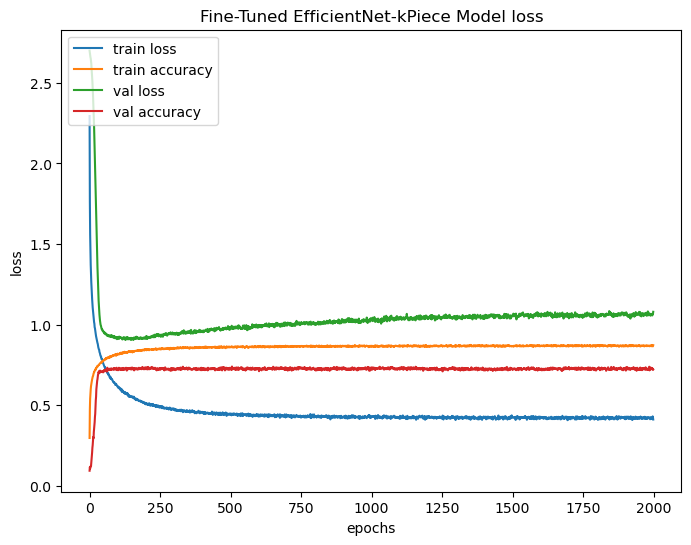

In [82]:
plot_train_loss(history, 'Fine-Tuned EfficientNet-kPiece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [83]:
train_preds = model1.predict(fine_tune_data_train)

  1/475 [..............................] - ETA: 23s

2022-10-07 05:40:42.216261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 2ms/step


In [84]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [85]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [87]:
np.sum(train_pred_labels == train_labels['label'])

14693

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [88]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
34,37,./Data/train/train/37.tif,5
39,43,./Data/train/train/43.tif,5
93,101,./Data/train/train/101.tif,13
130,140,./Data/train/train/140.tif,13
146,157,./Data/train/train/157.tif,5
...,...,...,...
15075,15874,./Data/train/train/15874.tif,6
15078,15877,./Data/train/train/15877.tif,1
15094,15893,./Data/train/train/15893.tif,13
15105,15904,./Data/train/train/15904.tif,11


In [103]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.953347,0.961145,0.957230,978
1,0.921218,0.948108,0.934470,925
2,0.989293,0.998919,0.994083,925
3,0.993697,0.998944,0.996314,947
4,0.998919,0.993548,0.996226,930
5,0.914195,0.897089,0.905561,962
6,0.990991,0.991984,0.991487,998
7,0.974642,0.968237,0.971429,913
8,0.973837,1.000000,0.986745,1005
9,0.986345,0.985310,0.985827,953


#### On Train-Test Data

In [104]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 3ms/step


In [105]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [106]:
test_pred_labels

array([11,  8,  5,  7,  1,  9,  5,  8, 14,  1,  6,  0,  7, 14,  1, 11,  0,
        9,  6, 10, 12, 14,  3,  9,  6,  0,  3,  3,  3,  3, 11,  1,  6,  2,
        1,  8,  9,  7,  1,  9,  6, 12, 14,  5,  7, 14,  1,  0, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15,  6,  5,  7,  0,  1,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11, 15, 13, 12,  9,
        8,  5, 12, 13, 13, 10, 11,  4, 10,  1, 10, 11, 11, 13, 10,  3,  1,
        5,  9,  1, 14,  8,  2,  1,  4,  7, 10,  9,  4, 12, 15, 12,  1, 10,
        6, 11,  1,  0, 12,  1,  7, 10, 12, 15,  7,  3, 11,  6,  5,  6,  9,
       14,  0,  7,  2, 11,  8, 11, 12,  8, 10,  8,  4,  2, 13,  0, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  9, 10, 13,  8,  5,  4,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11,  0, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10,  1, 11, 15,  1,  9,  1,
        9,  5, 13, 15, 12,  1,  4,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  7

In [107]:
np.sum(test_pred_labels == test_labels['label'])

577

In [108]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
6,84,./Data/train/train/84.tif,13
7,100,./Data/train/train/100.tif,10
...,...,...,...
783,15589,./Data/train/train/15589.tif,5
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12
793,15762,./Data/train/train/15762.tif,13


In [109]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.711538,0.685185,0.698113,54
1,0.484375,0.704545,0.574074,44
2,0.923077,0.837209,0.878049,43
3,0.977778,0.956522,0.967033,46
4,0.823529,0.777778,0.800000,36
5,0.520000,0.520000,0.520000,50
6,0.837209,0.782609,0.808989,46
7,0.745455,0.788462,0.766355,52
8,0.836066,0.944444,0.886957,54
9,0.739130,0.723404,0.731183,47


In [110]:
np.mean(fscore)

0.7248454298303675

#### On Validation Data

Generating Predictions for the Validation Set

In [111]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 4ms/step


2022-10-07 05:47:02.463086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [113]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

In [114]:
valid_pred_labels

array([ 4,  6,  4,  8,  3, 12, 11,  1,  2,  4,  3,  0,  5, 12, 13,  9,  1,
        1, 11, 12, 14,  9, 13,  6,  1,  2,  7,  3,  5,  1,  0, 14,  8, 10,
       14,  6, 11,  8,  6, 10,  4,  5, 12,  3,  2, 10,  3,  2,  6,  2,  5,
        9, 13,  0,  1, 15,  0,  3, 13, 12,  2,  7, 13, 14,  2,  8,  9,  7,
        5,  4, 11,  5,  7,  8,  4,  9,  4, 15, 11,  0,  9, 15, 11,  6,  1,
        5, 11,  0, 12, 10, 11,  5,  5, 15, 11,  4, 11, 10,  7,  6,  6, 11,
        7, 12,  7,  1, 15,  9, 10,  1,  7,  5, 10, 14,  2,  4,  7, 14,  7,
        1, 12, 15,  3,  6, 12, 10,  0,  6,  4, 12,  8,  1, 13,  8, 10,  3,
       15, 11, 11, 15,  6,  7,  2,  3,  2,  9,  9, 15, 15, 14,  6, 10,  5,
        8,  7,  3, 15,  1, 11, 14,  3,  1,  2,  5, 10, 10,  4, 13, 14, 13,
        5, 10,  4,  7,  4,  0,  1,  6, 15,  8,  5, 11,  4,  2,  3,  1,  0,
        9,  4,  2,  9,  5,  6,  2,  9, 10,  2,  9, 12,  7,  7, 13,  1,  0,
       15,  1,  4,  1,  4,  9, 10,  6,  6,  7,  4,  4, 13,  3, 10, 12, 13,
        6, 13,  8, 10,  5

### Submission

For Kaggle Submission

In [115]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,13
898,18699,0


In [116]:
submission_data.to_csv('./Submissions/submission-effnet-kPiece-corrected.csv', index=False)